***
# Monte-Carlo Uncertainty Quantification for Keane/Wolpin(1997)
***

## Introduction

When economists write model-driven scientific contributions, they usually calibrate their models by taking the mean paramters from selected estimation studies in the literature.
Normally, they do not care about the reported variance of these estimation studies. Then, after they run their model, they obtain only a vector of model outputs. Perhaps in the next stage, these outputs are used as benchmarks for policy advices. Yet, they have completely neglected the uncertainty in their vector of input paramters, that accompanied the means in the estimation studies. Obviously, this habit is very troublesome. Here, we take a first step in dealing with this problem in the conceptually most simple - but computationally most expensive - way.

This notebook executes an Uncertainty Quantification (UQ) in the narrow sense. The question that the UQ adresses is "To which distribution of model outputs does a model of choice propagate the (joint) distribution of a number of uncertain input parameters?". Henceforth, the model outputs are also named Quantities of Interest (QoIs).

Our model of choice is the Extended Dynamic Discrete Occupation Choice Model developed in

[Keane, M. P. & Wolpin, W. I. (1997). The career Decisions of Young Men., *Journal of Political Economy, 105(3): 473-552.*105(3): 473-552.](https://www.jstor.org/stable/10.1086/262080?seq=1#page_scan_tab_contents)

Here it will also be called 'KW97'. Our QoIs are, first, the 'education statistics' in table 14 (KW97: page 513) and the 'variance ratio' that refers to table 12 (KW97: page 509).
More precisely, the first QoIs, education statistics, are the Percentage of high school graduates, the Percentage of college graduates, Mean schooling and Mean years in College for All Types and for Type 1, Type 2, Type 3 and Type 4, seperately. The values are computed for the extended model and for the same model but under the 'Policy' of subsidizing college tuition costs by $2000. The second QoI is "the ratio of between-type variance in expected lifetime utility to the total variance" (KW97: page 508).

This notebook fails to replicate these statistics. Yet, for the first QoIs, it obtains results that have the right proportions to each other compared to KW97.
Nonetheless, an Uncertainty Quantification is conducted to illustrate the procedure. For that purpose, 1000 input paramters vectors are drawn randomly from a joint normal distribution The means are taken from the paper but the covariance matrix is fictional. Note that for the first QoIs, the UQ is only done for the policy effect and for All Types taken together. The reason for the reduction is high computation time.

**Informal Remark:**

To replicate the study, an installed version of respy from the develop branch at commit '7d035c0' is required.


(The command is `pip install git+git://github.com/OpenSourceEconomics/respy.git@7d035c0dcd1ea1d17cd02741408411e7eec5c5b8`.
The command is also implemented in `utils\travis_runner.sh`)

The newest version includes a different simulate function and also a missing $log_{e}$-operator in the reward function for wages. The second addition potentially explains why I am not able to fully replicate the values in table 14. Yet, using the newest version, I obtain results that are drastically too small compared to Keane/Wolpin(1997): They are partly ~$10^{2}$ times smaller than the results I present here. The latest information from saturday morning is, that I now have to take the exponent of all constant terms in the paramter vector. This will be done in future work.

***
# Section I: Uncertainty Quantification

Uncertainty quantification (UQ) is the science of quantitative characterization and reduction of uncertainties in both computational and real world applications. It tries to determine how likely certain outcomes are if some aspects of the system are not exactly known.

Sources of Uncertainty can be Parameter uncertainty, Parametric variability, Structural uncertainty, Algorithmic uncertainty and Interpolation uncertainty. This notebook is concerned with the first Source of Uncertainty: Paramter uncertainty.

Parameter Uncertainty originates from the model parameters that are inputs to the model but whose exact values are unknown to experimentalists and cannot be controlled in physical experiments, or whose values cannot be exactly inferred by statistical methods. A prominent example in economics would be preference paramters. All three scientic methods are not successful in determinig preference paramters as the variability of results within the respective scientific literature indicates. 

One can also think of our problem as *Forward uncertainty propagation problem*. Uncertainty propagation is the quantification of uncertainties in system outputs propagated from uncertain inputs. The targets of uncertainty propagation analysis can be:

- To evaluate low-order moments of the outputs, i.e. mean and variance.
- To evaluate the reliability of the outputs.
- To assess the complete probability distribution of the outputs.

The scope of this notebook is the first and the last target. This work is thought to be a starting point. Therefore, a Monte-Carlo simulation is chosen over theoretically more demanding methods. The procedure is to first draw a large number of vectors from the joint distribution of input paramters. Second the distributions of our Quantities of Interest are analyzed. The Model and its QoIs are outlined in the next section.

The next subchapter shortly sketches the Monte-Carlo procedure. An informed reader might want to continue directly with the next chapter.

### Example: Sketched Uncertainty Quantification

The following shall be understood as a sketch to illustrate a Monte Carlo Uncertainty Quantification rather than a comprehensive analysis.


Let the model be $m(x)=2x$ and $x \sim Uniform(0,0.5)$. 
Note that in the actual UQ there will be an input paramter vector instead of a scalar and that we will sample from a multidimensional normal joint distribution function characterized by a mean vector and a covariance matrix instead from a one-dimensional uniform distribution describe by one lower and one upper bound.

Recall that we want to answer the following questions:
What are the mean and the variance of our (only) QoI? How is the QoI distributed?And furthermore, how fast does our estimator for mean and variance converge?

Consider the following easy code that runs a full UQ:

'True Expectation Value:'

0.5

'Monte Carlo Expectation Value:'

0.5029230594882684

'True Variance:'

0.08333333333333333

'Monte Carlo Variance:'

0.08427931094334803

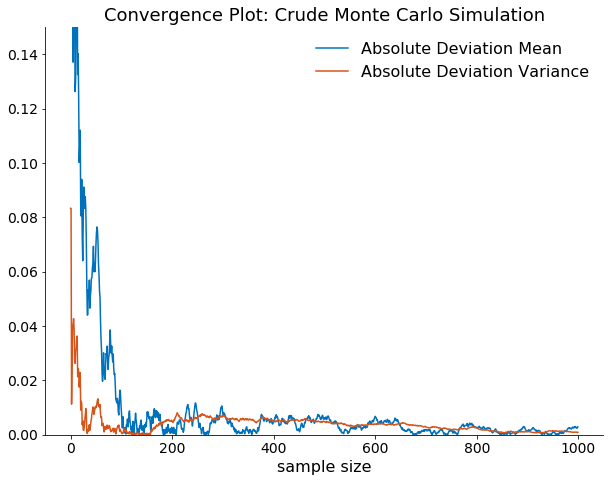

In [1]:
%matplotlib inline
import numpy as np

from notebook_material.notebook_plots import *


n_draws = 1000
sample = np.random.uniform(0, 0.5, n_draws)

def m(u):
    return 2*u

true_E_model = 0.5
true_Var_model = 1/12

mc_E = np.zeros(n_draws)
mc_Var = np.zeros(n_draws)

for s in range(0, n_draws, 1):
    # draw random samples from u
    samples_u = sample[0:s+1]
    samples_model = [m(r) for r in samples_u]
    mc_E[s] = np.mean(samples_model)
    mc_Var[s] = np.var(samples_model)

notebook_convergence_plot(mc_E, true_E_model, mc_Var, true_Var_model)

display('True Expectation Value:',true_E_model, 'Monte Carlo Expectation Value:', mc_E[n_draws-1], 'True Variance:', true_Var_model, 'Monte Carlo Variance:', mc_Var[n_draws-1])

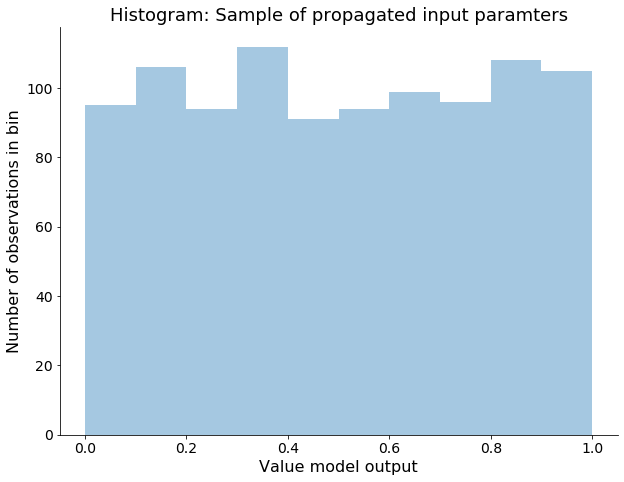

In [2]:
# create histogram of QoI
notebook_histogram(samples_model)

The computations and graphs show the folliwing: The mean of the simulation corresponds roughly to the actual man. But the variance differences are quite pronounced. These facts are also captured in the convergence plot. We also see that, although the model and the distribution of the input paramter are very simple, the convergence does not satisfy high requirements for 1000 draws. This leads to the early result that we have to run a serious Monte Carlo Uncertainty Quantification on a more powerful computer for our actual model as well.

Our actual model is presented in the next section. Though more complex and of higher dimension, the (programming) steps that we will take in the Uncertainty Quantification Section are exactly the same as for our sketched example.

***
# Section II: The Model

This section briefly presents the Extended Dynamic Discrete Occupation Choice Model by Keane/Wolpin (1997).

#### The Basic Human Capital Model

The core of the Extended Model is the basic model that was developed prior but failed to match many dimensions of the data because it was too simplistic.


In the basic version, individuals enter the model at age 16 and decide in each period in which of the following five mutually exclusive sectors they will participate:
Blue-Collar ($m=1$), white-collar ($m=2$), military ($m=3$), school ($m=4$) or home production sector ($m=5$). Each choice is characterized by direct rewards and costs.
For the choice of employment in one of the first sectors, the reward is $R_m(a)$ with $m=\{1,2,3\}$ at age $a$. The respective wage $w_m(a)$ is given by: 
\begin{align*}
&&&&\\
&&&&\\
w_m(a) & = r_m \times exp[e_{km}(16) + e_{m1}g(a) + e_{m2}x_m(a) - e_{m3}x_m^2(a) + e_{m4}x_2(a) + e_{m5}x_3(a) + \epsilon_m(a)] \quad \text{for} \quad m=1, \\
&&&&\\
w_m(a) & = r_m \times exp[e_{km}(16) + e_{m1}g(a) + e_{m2}x_m(a) + e_{m3}x_m^2(a) - e_{m4}x_2(a) + e_{m5}x_3(a) + \epsilon_m(a)] \quad \text{for} \quad m=2, \\
&&&&\\
w_m(a) &  = r_m \times exp[e_{km}(16) + e_{m1}g(a) + e_{m2}x_m(a) + e_{m3}x_m^2(a) + e_{m4}x_2(a) - e_{m5}x_3(a) + \epsilon_m(a)] \quad \text{for} \quad m=3 \\
&&&&\\
&&&&\\
\end{align*}
Thus, the occupation-specific wage is the product of $r_m$, the exogenous rental price of human capital, and the respective occupation-specific skill that was accumulated until period $a$. These occupation-specific skills consist of years of schooling $g(a)$, years of occupation-specific experience $x_m(a)$, the type-specific endowment of skills at age 16 $e_{km}(16)$, and the occupation-specific technology schock $\epsilon_m(a)$. For blue and white-collar occupation, linear cross-experience terms enter the wage equation, but not for the military occupation. The $e_{mk}$ parameter vector, for $k \: \epsilon \: \{1,...,4\}$, captures returns to schooling and human capital.
$k$ denotes types of different level of comparative advantages that capture the unobserved permanent heterogeneity in the model when calibrated to the data. It enables some individuals to earn higher rewards in some sectors than other individuals.

Schooling yields rewards as a function of type-specific skill endowment at age 16, college and graduate school tuition costs and random shocks. The rewards for home production are a function of type-specific skill endowment at age 16 and random shocks. 

Contemporaneous random shocks to human capital $\epsilon_m(a)$ are observables to the individuals but not to the beholder. Yet, future shocks are not foreseeable for both. They are defined as jointly normally distributed with zero mean and serially uncorellated conditional on the unobserved endowments. While the last component of the assumption is rather artifical, it simplifies the model solution.

#### Model solution

The agents who populate the model are rational and forward-looking. Abstractly speaking, they choose the one occupation each period given the realizations of present shocks that maximizes the expected sum of present and future discounted life-time returns. Formally, 
\begin{align*}
&&&&\\
&&&&\\
V(S(a),a) = \max_{d_m(a)} E[\sum_{\tau=a}^A \delta^{\tau-a} \sum_{m=1}^5 R_m(a)d_m(a) | S(a)]
&&&&\\
&&&&\\
\end{align*}
where $0 < \delta < 1$ is the discout factor, $d_m(a)$ is an occupation-specific indicator function and $S(a)$ represents the whole state space. The state space contains the agents' information about contemporaneous shocks, the endowments and the history of choices. The above equation can be spelled as a Bellman Equation and its solution constitutes a Dynamic Programming Problem. Choices are discrete, the model involves randomness and the agents are rational. Thefore, each solution to the Bellman equation enters a maximum likelohood estimation of the model paramters vector. The Likeloohood of observing a sequence of choices $c(a)$ for an individual is given by
\begin{align*}
&&&&\\
Pr[c(16),...,c(\overline{a})|e(16),g(16)] = \Pi_{a=16}^{\overline{a}} Pr[c(a) | e(16),g(a),x(a)]
&&&&\\
&&&&\\
&&&&\\
\end{align*}
where $e(16)$ denotes the endowment vector of the five alternatives and $x(a)$ denotes the work experience for the three employment sectors.
The sample likelihood function equals the product of the likelihood function of all individuals. For each choice paramter, the Bellman equation is maximized. In a next step the solution vector is passed to the likelihood function. Then the sample likelihood is maximized.

#### The Extended Human Capital Model

The basic human capital model does not fit the NLSY data well. Therefore, Keane and Wolpin extended the model by several features.
The extensions serve to improve the overall choice disitrubtion and the pattern of persistence of occupatiotion choices. The extensions affect the following model features: Skill technology functions, Mobility and job search costs, Nonpecuniary rewards plus indirect comnpensation, School attendance, Remaining at home and Common Returns.

First, the civilian skill production function were augmented to allow for a skill depreciation effect, a first-year experience effect, age effects and high school and college graduation effects. Second, the reward functions for the civilian occupations were augmented to include a direct monetary job-finding cost. Third, Nonpecuniary rewards plus indirect compensation that capture non-wage aspects of employment are introduced. Fourth, the schooling rewards is more generally interpreted to include a consumption value of school attendance and is allowed to depend systematically on age. Furthermore, the rewards of attending school includes a cost of re-entry into high school and secondary school.
Fifth, the payoff from remaining home is allowed to differ by age. Lastly, rewards representing a psychic value associated with earning a high school diploma and a college diploma are added.


## Extended model causal graph
The below causal graph illustrates the causal structure within the extended model, All inputs influence the choice outcome in $t+1$. Therefore a causal arrow points directly from $state_t$ to $state_{t+1}$ to capture the transition of choice in the extended model. The intuition is that choice tends to persist over periods depending on age, $state_t$ has a direct effect on the $state_{t+1}$ outcomes. Keane & Wolpin also take into account unobserved endowment heterogeneity (represented as unobserved characteristics in the causal graph) in determining inequality in lifetime welfare by categorizing observations by Type 1 to Type 4. Although a beholder outside the model cannot observe an individual's type directly, they use Baye's rule to compute the probability distribution of the endowment types conditioning on choices, wages and initial schooling. Having calculated these endowment type probabilities for each individual, they determine the extent to which observed family background characteristics are relevant to type. The results indicate that standard measures of family background account for 10% of the variation in expected lifetime utility that arises from endowment heterogeneity. Hence, the authors infer that in order to understand the sources of endowment heterogeneity, obtaining measurements of investments in children before age 16, including prenatal care and maternal behaviors during pregnancy, child care, child nutrition, grade school experiences, and so forth, is crucial. These factors are captured by the node *other unobservables*

![](notebook_material/causal_graph.png)

In [3]:
# in case the reader wants to check the values
import pickle

with open('auxiliary/results/repl_edu_stats.pkl', 'rb') as f:
    repl_policy_impact = pickle.load(f)
with open('auxiliary/results/repl_policy_impact.pkl', 'rb') as f:
    repl_policy_impact = pickle.load(f)
with open('auxiliary/results/repl_var_ratio.pkl', 'rb') as f:
    repl_var_ratio = pickle.load(f)    
with open('auxiliary/results/var_mc_policy_edu_stats.pkl', 'rb') as f:
    var_mc_policy_edu_stats = pickle.load(f) 
with open('auxiliary/results/var_mc_var_ratio.pkl', 'rb') as f:
    var_mc_var_ratio = pickle.load(f)   
with open('auxiliary/results/mean_mc_policy_edu_stats.pkl', 'rb') as f:
    mean_mc_policy_edu_stats = pickle.load(f)    
with open('auxiliary/results/mean_mc_var_ratio.pkl', 'rb') as f:
    mean_mc_var_ratio = pickle.load(f)

***
# Section III: Replication - Quantities of Interest 1
The first QoIs are the 'education statistics' in table 14 (KW97: page 513). More precisely, education statistics are the Percentage of high school graduates, the Percentage of college graduates, Mean schooling and Mean years in College for All Types and for Type 1, Type 2, Type 3 and Type 4, seperately. These values are computed for the extended model and for the same model but under the 'Policy' of subsidizing college tuition costs by $2000. Keane&Wolpin computed these values based on a simulation of 5000 agents. They report the following results:

## <center> Table 14 in Keane/Wolpin (1997) </center>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">All Types</th>
    <th class="tg-0pky">Type 1</th>
    <th class="tg-0pky">Type 2</th>
    <th class="tg-0pky">Type 3</th>
    <th class="tg-0pky">Type 4</th>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Percentage high school graduates:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;No subsidy</td>
    <td class="tg-0pky">74.8</td>
    <td class="tg-0pky">100.0</td>
    <td class="tg-0pky">68.6</td>
    <td class="tg-0pky">70.2</td>
    <td class="tg-0pky">67.0</td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0pky">78.3</td>
    <td class="tg-0pky">100.0</td>
    <td class="tg-0pky">73.2</td>
    <td class="tg-0pky">74.0</td>
    <td class="tg-0pky">72.2</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Percentage college graduates:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;No subsidy</td>
    <td class="tg-0pky">28.3</td>
    <td class="tg-0pky">98.7</td>
    <td class="tg-0pky">11.1</td>
    <td class="tg-0pky">8.6</td>
    <td class="tg-0pky">19.5</td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0pky">36.7</td>
    <td class="tg-0pky">99.5</td>
    <td class="tg-0pky">21.0</td>
    <td class="tg-0pky">17.1</td>
    <td class="tg-0pky">32.9</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Mean schooling:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;No subsidy</td>
    <td class="tg-0pky">13.0</td>
    <td class="tg-0pky">17.0</td>
    <td class="tg-0pky">12.1</td>
    <td class="tg-0pky">12.0</td>
    <td class="tg-0pky">12.4</td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0pky">13.5</td>
    <td class="tg-0pky">17.0</td>
    <td class="tg-0pky">12.7</td>
    <td class="tg-0pky">12.5</td>
    <td class="tg-0pky">13.0</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Mean years in school:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;No subsidy</td>
    <td class="tg-0pky">1.34</td>
    <td class="tg-0pky">3.97</td>
    <td class="tg-0pky">0.69</td>
    <td class="tg-0pky">0.59</td>
    <td class="tg-0pky">1.05</td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0pky">1.71</td>
    <td class="tg-0pky">3.99</td>
    <td class="tg-0pky">1.14</td>
    <td class="tg-0pky">1.00</td>
    <td class="tg-0pky">1.58</td>
  </tr>
</table>

<br>

The computations of all replications are run by the script `auxiliary\kw97_replication.py`. There, the samples of 5,000 persons for the extended model without Subsidy and with the Policy of reducing the college tuition costs by $\$2,000$ are generated. The script then calls
the function `data_replication` from `auxiliary\stats_functions\data_statistics.py`. The function `data_replication` essentially calls the function `utility_statistics` from module `utility_statistics.py` in the same folder. `data_replication` then dumps the returned arrays as a pickle.
I tested the function `utility statistics` for all type groups on an imaginary dataframe in the module `tests.py` which can be found in `auxiliary\tests`.
In our notebook, the arrays that contain the data in the table below can be called by typing `repl_edu_stats`.

As the table below shows, the large majority of the statistics is more than $20\%$ too small compared to KW97. Yet, as in KW97, all Subsidy values are larger than their respective No Subsidy values. This is further illustrated in the second table below which shows the Effect of the Subsidy. Additionally, the size ranking amongst all statistics for each Type group is also the same as in KW97. This indicates, that the dataframe on which the function `utility_statistics` is run, is not the same as the one of Keane&Wolpin. As already mentioned, the data is generated in `auxiliary\kw97_replication.py`. Yet, one pattern is striking: The deviation of our computations are much larger for the Type 2 and Type 3 compared to Type 1 and Type 4. Additionally, the computations for college attendancy are also worse than the ones for high school and school in general. This can be explained by the fact, that college is the highest and thus the most sensitive education statistic in the table.

## <center> Computation Table 14 </center>

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-cly1{text-align:left;vertical-align:middle}

.tg-sort-header::-moz-selection{background:0 0}.tg-sort-header::selection{background:0 0}.tg-sort-header{cursor:pointer}.tg-sort-header:after{content:'';float:right;margin-top:7px;border-width:0 5px 5px;border-style:solid;border-color:#404040 transparent;visibility:hidden}.tg-sort-header:hover:after{visibility:visible}.tg-sort-asc:after,.tg-sort-asc:hover:after,.tg-sort-desc:after{visibility:visible;opacity:.4}.tg-sort-desc:after{border-bottom:none;border-width:5px 5px 0}</style>
<table id="tg-WQU52" class="tg">
  <tr>
    <th class="tg-cly1"></th>
    <th class="tg-0lax">All Types</th>
    <th class="tg-0lax">Type 1</th>
    <th class="tg-0lax">Type 2</th>
    <th class="tg-0lax">Type 3</th>
    <th class="tg-0lax">Type 4</th>
  </tr>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Percentage high school graduates:</span></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;No Subsidy</td>
    <td class="tg-0lax">55.3</td>
    <td class="tg-0lax">99.5</td>
    <td class="tg-0lax">40.9</td>
    <td class="tg-0lax">31.0</td>
    <td class="tg-0lax">62.6</td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0lax">58.8</td>
    <td class="tg-0lax">99.8</td>
    <td class="tg-0lax">45.0</td>
    <td class="tg-0lax">32.7</td>
    <td class="tg-0lax">68.7</td>
  </tr>
  <tr>
    <td class="tg-cly1"><span style="font-weight:bold">Percentage college graduates:</span></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;No Subsidy</td>
    <td class="tg-0lax">20.7</td>
    <td class="tg-0lax">78.8</td>
    <td class="tg-0lax">04.5</td>
    <td class="tg-0lax">01.1</td>
    <td class="tg-0lax">01.5</td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0lax">27.2</td>
    <td class="tg-0lax">87.5</td>
    <td class="tg-0lax">09.4</td>
    <td class="tg-0lax">02.8</td>
    <td class="tg-0lax">02.6</td>
  </tr>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Mean schooling:</span></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;No Subsidy</td>
    <td class="tg-0lax">11.7</td>
    <td class="tg-0lax">15.7</td>
    <td class="tg-0lax">10.5</td>
    <td class="tg-0lax">10.1</td>
    <td class="tg-0lax">11.8</td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0lax">12.1</td>
    <td class="tg-0lax">16.0</td>
    <td class="tg-0lax">10.9</td>
    <td class="tg-0lax">10.2</td>
    <td class="tg-0lax">12.5</td>
  </tr>
  <tr>
    <td class="tg-0lax"><span style="font-weight:bold">Mean years in college:</span></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
    <td class="tg-0lax"></td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;No Subsidy</td>
    <td class="tg-0lax">1.04</td>
    <td class="tg-0lax">3.66</td>
    <td class="tg-0lax">0.32</td>
    <td class="tg-0lax">0.12</td>
    <td class="tg-0lax">0.81</td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy</td>
    <td class="tg-0lax">1.34</td>
    <td class="tg-0lax">4.02</td>
    <td class="tg-0lax">0.56</td>
    <td class="tg-0lax">0.22</td>
    <td class="tg-0lax">1.33</td>
  </tr>
</table>
<script charset="utf-8">var TGSort=window.TGSort||function(n){"use strict";function r(n){return n.length}function t(n,t){if(n)for(var e=0,a=r(n);a>e;++e)t(n[e],e)}function e(n){return n.split("").reverse().join("")}function a(n){var e=n[0];return t(n,function(n){for(;!n.startsWith(e);)e=e.substring(0,r(e)-1)}),r(e)}function o(n,r){return-1!=n.map(r).indexOf(!0)}function u(n,r){return function(t){var e="";return t.replace(n,function(n,t,a){return e=t.replace(r,"")+"."+(a||"").substring(1)}),l(e)}}function i(n){var t=l(n);return!isNaN(t)&&r(""+t)+1>=r(n)?t:NaN}function s(n){var e=[];return t([i,m,g],function(t){var a;r(e)||o(a=n.map(t),isNaN)||(e=a)}),e}function c(n){var t=s(n);if(!r(t)){var o=a(n),u=a(n.map(e)),i=n.map(function(n){return n.substring(o,r(n)-u)});t=s(i)}return t}function f(n){var r=n.map(Date.parse);return o(r,isNaN)?[]:r}function v(n,r){r(n),t(n.childNodes,function(n){v(n,r)})}function d(n){var r,t=[],e=[];return v(n,function(n){var a=n.nodeName;"TR"==a?(r=[],t.push(r),e.push(n)):("TD"==a||"TH"==a)&&r.push(n)}),[t,e]}function p(n){if("TABLE"==n.nodeName){for(var e=d(n),a=e[0],o=e[1],u=r(a),i=u>1&&r(a[0])<r(a[1])?1:0,s=i+1,v=a[i],p=r(v),l=[],m=[],g=[],h=s;u>h;++h){for(var N=0;p>N;++N){r(m)<p&&m.push([]);var T=a[h][N],C=T.textContent||T.innerText||"";m[N].push(C.trim())}g.push(h-s)}var L="tg-sort-asc",E="tg-sort-desc",b=function(){for(var n=0;p>n;++n){var r=v[n].classList;r.remove(L),r.remove(E),l[n]=0}};t(v,function(n,t){l[t]=0;var e=n.classList;e.add("tg-sort-header"),n.addEventListener("click",function(){function n(n,r){var t=d[n],e=d[r];return t>e?a:e>t?-a:a*(n-r)}var a=l[t];b(),a=1==a?-1:+!a,a&&e.add(a>0?L:E),l[t]=a;var i=m[t],v=function(n,r){return a*i[n].localeCompare(i[r])||a*(n-r)},d=c(i);(r(d)||r(d=f(i)))&&(v=n);var p=g.slice();p.sort(v);for(var h=null,N=s;u>N;++N)h=o[N].parentNode,h.removeChild(o[N]);for(var N=s;u>N;++N)h.appendChild(o[s+p[N-s]])})})}}var l=parseFloat,m=u(/^(?:\s*)([+-]?(?:\d+)(?:,\d{3})*)(\.\d*)?$/g,/,/g),g=u(/^(?:\s*)([+-]?(?:\d+)(?:\.\d{3})*)(,\d*)?$/g,/\./g);n.addEventListener("DOMContentLoaded",function(){for(var t=n.getElementsByClassName("tg"),e=0;e<r(t);++e)try{p(t[e])}catch(a){}})}(document);</script>

<br>

## <center> Computation Subsidy Effect Table 14 </center>


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-cly1{text-align:left;vertical-align:middle}

</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">All Types</th>
    <th class="tg-0pky">Type 1</th>
    <th class="tg-0pky">Type 2</th>
    <th class="tg-0pky">Type 3</th>
    <th class="tg-0pky">Type 4</th>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Percentage high school graduates:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">    Subsidy effect<br></td>
    <td class="tg-0pky">3.24</td>
    <td class="tg-0pky">0.30</td>
    <td class="tg-0pky">4.11</td>
    <td class="tg-0pky">1.70</td>
    <td class="tg-0pky">6.14</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Percentage college school graduates:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect</td>
    <td class="tg-0pky">6.50</td>
    <td class="tg-0pky">8.70</td>
    <td class="tg-0pky">4.90</td>
    <td class="tg-0pky">1.70</td>
    <td class="tg-0pky">11.50</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Mean schooling:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect</td>
    <td class="tg-0pky">0.39</td>
    <td class="tg-0pky">0.36<br></td>
    <td class="tg-0pky">0.37</td>
    <td class="tg-0pky">0.14</td>
    <td class="tg-0pky">0.70</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Mean years in college:</span></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
    <td class="tg-0pky"></td>
  </tr>
  <tr>
    <td class="tg-0pky">    Subsidy effect</td>
    <td class="tg-0pky">0.30</td>
    <td class="tg-0pky">0.36</td>
    <td class="tg-0pky">0.24</td>
    <td class="tg-0pky">0.10</td>
    <td class="tg-0pky">0.53</td>
  </tr>
</table>

<br>

### Informal Remark:

The problem  can potentially be solved by using the latest update from respy from 31.07.2019 which (quote commit name) "converts rental price in params to log rental price" AND then taking the exponent of the values in the paramters vector that end with "_constant". Without the last transformation, the results are drastically to low, partly by factor 100. Due to time constraints I write this notebook with the data that I simulated in the night from 02.08.2019 to 03.08.2019

***
# Section IV: Replication - Quantities of Interest 2

One of the most prominently featured results of KW97 emphasized the dramatic importance of comparative advantages in labor markets: Initial heterogeneity (at the age of 16) accounts for 90 percent of the variation in life-cycle utility. Or, to quote directly: "Indeed, on the basis of the simulated data, the between-type variance in expected lifetime utility is calculated to account for 90 percent of the total variance." (KW97: page 508).

I use *respy* to compute the same statistic. The interested reader can find the code in `auxiliary\stats_functions\utility_statistics.py`. I assume that the authors refer to the expected discounted lifetime utility by actually writing "expected lifetime utility" because the discounted factor plays an important role in evaluating the series of utility per period over a lifespan. The expected discounted lifetime utility is formally given by the Value function of each agent. Thus, I simulate 5000 agents using the baseline setting of the Extended Model without any policy intervention. The only statistics that are needed are the Value functions for each occupation choice in the first period and the Type of each agent. The maximum of the Value function for each occupation choice represents the actual Value function.


The abstract mathematical setting is described by the following paragraph taken from *Statistik: Grundlagen und Methodik* by Toni Stocker from the Economics Department at the University of Mannheim and by Ingo Steinke:

#### Variance decomposition formula for grouped data:

For metrically scaled observations $x_1,...,x_2$ grouped in $k$ groups, the following variance decomposition formula holds:

\begin{align*}
&&&&\\
&&&&\\
\tilde{s}^2 = \frac{1}{n} \sum_{i=1}{n} (x_i - \bar{x})^2 =  \frac{1}{n} \sum_{j=1}^{k} n_j \tilde{s}_j^2 + \frac{1}{n} \sum_{j=1}^{k} n_j (x_j - \bar{x})^2
&&&&\\
&&&&\\
\end{align*}
 where $n_1,...,n_k$ denote the number of observations in each group and $\bar{x_1},...,\bar{x_k}$ and $\tilde{s}_1^2,...,\tilde{s}_k^2$ denote the group averages and group variances.
 
Verbally, the variance decomposition formula states that the total variance is the sum of the within-group variance and the between-group variance. The within-group variance is $\frac{1}{n} \sum_{j=1}^{k} n_j \tilde{s}_j^2$ which is group-specific internal variance in each group.
The between-group-variance is $\tilde{s}_1^2,...,\tilde{s}_k^2$. It is the squared deviation of group means from the mean of the whole sample. The mean of the whole sample is equal to the mean of group means. It is sometimes called the "mean of means".
The distinct addends of withing-group and between-group variances are weighted by the relative group shares $\frac{n_j}{n}$.  

Thus the expression that interests us in the context of KW97 is:
\begin{align*}
&&&&\\
&&&&\\
\frac{\frac{1}{n} \sum_{j=1}^{k} n_j (x_j - \bar{x})^2}{\frac{1}{n} \sum_{i=1}{n} (x_i - \bar{x})^2}
&&&&\\
&&&&\\
\end{align*}
The groups are the different intial endowment types, Type 1 to Type 4. Thus $k=4$.
The number that I compute is :

In [4]:
repl_var_ratio[0]

0.9870480552205939

Thus the deviation from the figure in KW97 is 8.7%. That is large.

Three validity checks are conducted during the computations:
- The type group weights sum to 1
- the between-group variance is smaller than the total variance
- the total variance is the sum of within-group variance and between-group variance

The respective lines of code are:

`assert abs(sum(type_weights) - 1) <= 0.02`

`assert ratio <= 1`

`assert within_group_var + bw_group_var - var <= 0.0001`


***
# Section V: Uncertainty Quantification

In this section, the same procedure as sketched in the one-dimensional example in Section 1 is executed for the high-dimensional model in Keane/Wolpin(1997). 
The difference is that we sample from a joint distribution with an expectation value and a covariance matrix (that allows for correlations). In this notebook, we assume the input parameters to be jointly normally distributed. Further, but not necessary assumptions on the covariance matrix are that there are no correlations between paramters, i.e. only the main diagonal has non-zero elements. The fictional covariance matrix that I use sets the variance of the paramters on position 47 to position 61 to 1000. The number and positions are chosen rather arbitrary, but in a way that the model is solveable and that the scale of the paramters is not too unsimilar.

To account for the accumulating computation time in a Monte-Carlo setting, the Quantities of Interest have been adjusted:
Now, the Quantities of Interest 1 are the Effect of a Subsidy for All Types on the education statistics. Explicitly, the QoIs for All Types in the baseline extended model is subtracted from the QoIs under the annaul $2000 subsidy on the college tuition costs generated by a randomly drawn input paramter vector.

The number of draws is 1000. The approximate computation time on my mashine is 18 hours. Hence, one loop took slightly more than one minute to complete.

Another important aspect is, that a random seed is set in the simulate function of `respy`for replicability reasons. Yet, the seed can potentially influence the outcome of our study, depending on how represantitive the seed is. Therefore, I propose to compare the results using the seeded simulate function with the ones resulting from a unseeded function in future work. 

The results are summarized in the below table. Due to the complexitiy of the model and the arbitrariness with which the covariance matrix was set, no economic interpretation is given. However, note that the standard deviations are in a roughly similar range for the QoIs 1 given their scale (percentage vs unscaled). Yet the standard deviation for QoI 2 is a lot smaller.
One reason is the artifical scale of the variance, that squares the deviations from the mean to avoid cancellations of positive and negative deviations. The standard deviation for the same ratio, but composed of standard deviations instead of variances would be more in line with the QoIs 1.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-cly1"></th>
    <th class="tg-cly1"><span style="font-weight:bold">&nbsp;&nbsp;Mean</span></th>
    <th class="tg-cly1"><span style="font-weight:bold">Standard Deviation</span></th>
  </tr>
  <tr>
    <td class="tg-cly1"><span style="font-weight:bold">Quantities of Interest 1</span></td>
    <td class="tg-cly1"></td>
    <td class="tg-cly1"></td>
  </tr>
  <tr>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect on Percentage high school graduates</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;3.17</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.03</td>
  </tr>
  <tr>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect on Percentage college graduates</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;6.61</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.00</td>
  </tr>
  <tr>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect on Mean schooling</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;0.39</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.08</td>
  </tr>
  <tr>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;Subsidy effect on Mean years in college</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;0.30</td>
    <td class="tg-cly1">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.04</td>
  </tr>
  <tr>
    <td class="tg-cly1"><span style="font-weight:bold">Quantity of Interest 2</span></td>
    <td class="tg-cly1"></td>
    <td class="tg-cly1"></td>
  </tr>
  <tr>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;Between-type-variance-to-total-variance ratio</td>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;0.99</td>
    <td class="tg-0lax">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2e-5</td>
  </tr>
</table>


In the following, histograms for all QoI are depicted. It can be seen, that the normal distribution of the random input paramteters has been propaged through the model to each QoI. Furthermore, as expected, the distributions have not converged very well. Another striking feature is, that the distributions for the Subsidy Impact on Percentage of high school graduates, Mean years in schooling and Mean years in college are bimodal.

## <center> Histogram: Subsidy Impact on Percentage college graduates </center>
<img src="auxiliary/results/graphs/policy_impact_AllTypes_Percentagehighschoolgraduates.png" width="66%" align="center"/>

## <center> Histogram: Subsidy Impact on Percentage high school graduates </center>
<img src="auxiliary/results/graphs/policy_impact_AllTypes_Percentagecollegegraduates.png" width="66%" align="center"/>

## <center> Histogram: Subsidy Impact on Mean years in college </center>
<img src="auxiliary/results/graphs/policy_impact_AllTypes_Meanschooling.png" width="66%" align="center"/>

## <center> Histogram: Subsidy impact Mean years in College </center>
<img src="auxiliary/results/graphs/policy_impact_AllTypes_Meanyearsincollege.png" width="66%" align="center"/>

## <center> Histogram: Between-type-variance-to-variance ratio</center>
<img src="auxiliary/results/graphs/Subsidy_variance_ratio.png" width="66%" align="center"/>

The next graphs are a number of convergence plots for each QoI's mean. Each QoI's mean is converged to a deviation below 1% after 1000 random draws. Note that the Deviation of the QoIs 1 that are scaled in percantages is not scaled in percentage deviation in this plots. A pseudo-random/random pattern that these plots show is that all QoI converge from below. Furthermore, the degree to which a QoI is bimodally distributed is proportional to the degree to which the QoIs overshoot their means. Corresponding to the above histograms, the mean of QoI 2 converges much faster to the QoI under deterministic model input paramters compared to QoIs 1. The reasoning is the same.

## <center> Convergence Plot: Subsidy Impact on Percentage college graduates </center>

<img src="auxiliary/results/graphs/convergence_Percentage high school graduates.png" width="66%" align="center"/>

## <center> Convergence Plot: Subsidy Impact on Percentage high school graduates </center>

<img src="auxiliary/results/graphs/convergence_Percentage college graduates.png" width="66%" align="center"/>

## <center> Convergence Plot: Subsidy Impact on Mean schooling </center>

<img src="auxiliary/results/graphs/convergence_Mean schooling.png" width="66%" align="center"/>

## <center> Convergence Plot: Subsidy Impact on Mean years in college </center>

<img src="auxiliary/results/graphs/convergence_Mean years in college.png" width="66%" align="center"/>

## <center> Convergence Plot: Between-type-variance-to-total-variance ratio </center>

<img src="auxiliary/results/graphs/convergence_var_ratio.png" width="66%" align="center"/>

***
# Conclusion

Uncertainties in (economic) models should be made transparent. With regard to uncertain input paramters it was shown how easy an Uncertainty Propagation can be implemented via Monte-Carlo simulations. Yet, one needs the respective computational capacities to draw a sufficient number of input parameter vectors from its respective joint distribution.

For our Model of Interest, the computations will be re-run with an estimated covariance matrix for the input paramters to obtain meaningful results that can be analyzed and interpreted within the model framework and its economics.

The replication of our Quantities of Interest from Keane&Wolpin (1997) has not been finalized.
However, for the education statistics the next step is to take the exponent of the paramters that are called "constant" and to run the program with an updated version of `respy`.
It still remains unclear how the variance ratio was computed.

***
# References

[Keane, M. P. & Wopin, W. I. (1997). The career Decisions of Young Men., *Journal of Political Economy, 105(3): 473-552.*105(3): 473-552.](https://www.jstor.org/stable/10.1086/262080?seq=1#page_scan_tab_contents)

Stocker, Toni Clemens & Steinke, Ingo. 2017. Statistik: Grundlagen und Methodik. [1.] Oldenbourg: De Gruyter.